In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [102]:
col_titles = ["date", "min", "avg", "max"]
winter_df = pd.DataFrame(columns=col_titles)
summer_df = pd.DataFrame(columns=col_titles)

def getData(df, date):
    """ Takes in a dataframe and the date and inserts the min, avg, and
        max temperatures of that date to the dataframe. """

    url = requests.get("https://www.almanac.com/weather/history/IL/Chicago/" + date)
    content = url.text
    # soup = BeautifulSoup(content, 'html5lib')
    html = pd.read_html(content, header=0)[0]

    html["date"] = date
    data = [html.iloc[0][2], html.iloc[0][1], html.iloc[1][1], html.iloc[2][1]]
    df.loc[len(df)] = data

# Summer range: 1946-06-21 to 2020-09-22
# Winter range: 1945-12-21 to 2020-03-20
years = range(1946,2021)
summer_start = '06-21'
summer_end = '09-22'
winter_start = '12-21'
winter_end = '03-20'
summer_dates = []
winter_dates = []
for y in years:
    ss = str(y) + '-' + summer_start
    se = str(y) + '-' + summer_end
    ws = str(y-1) + '-' + winter_start
    we = str(y) + '-' + winter_end
    summer = pd.date_range(ss, se, freq = 'D')
    for s in summer:
        summer_dates.append(str(s.date()))
    winter = pd.date_range(ws, we, freq = 'D')
    for w in winter:
        winter_dates.append(str(w.date()))

In [98]:
batch = range(0, len(winter_dates), 1000)
for dates in [winter_dates[i : i + 1000] for i in batch]:
    for date in dates:
        getData(winter_df, date)
winter_df.to_csv("winter_data.csv")

In [106]:
batch = range(0, len(summer_dates), 500)

for dates in [summer_dates[i : i + 500] for i in batch]:
    for date in dates:
        getData(summer_df, date)       
summer_df.to_csv("summer_data.csv")


In [3]:
winter_df = pd.read_csv('winter_data.csv', index_col=0)
summer_df = pd.read_csv('summer_data.csv', index_col=0)

In [4]:
# Remove ºF from temperature data
def removeUnit(val):
    ''' Removes the unit from the value. Returns value.'''
    new = str(val)
    new = new[ : new.find(' ')]
    return new

winter_df['min'] = winter_df['min'].apply(removeUnit)
winter_df['avg'] = winter_df['avg'].apply(removeUnit)
winter_df['max'] = winter_df['max'].apply(removeUnit)
summer_df['min'] = summer_df['min'].apply(removeUnit)
summer_df['avg'] = summer_df['avg'].apply(removeUnit)
summer_df['max'] = summer_df['max'].apply(removeUnit)

# Create year column by extracting year from date column
winter_df['date'] = pd.to_datetime(winter_df['date'])
summer_df['date'] = pd.to_datetime(summer_df['date'])
winter_df['year'] = pd.DatetimeIndex(winter_df['date']).year
summer_df['year'] = pd.DatetimeIndex(summer_df['date']).year

winter_df['min'] = pd.to_numeric(winter_df['min'])
winter_df['avg'] = pd.to_numeric(winter_df['avg'])
winter_df['max'] = pd.to_numeric(winter_df['max'])
summer_df['min'] = pd.to_numeric(summer_df['min'])
summer_df['avg'] = pd.to_numeric(summer_df['avg'])
summer_df['max'] = pd.to_numeric(summer_df['max'])

winter_min_summary_df = winter_df.groupby(['year'])['min'].describe()
winter_min_summary_df.to_csv('winter_min_summary')
winter_avg_summary_df = winter_df.groupby(['year'])['avg'].describe()
winter_avg_summary_df.to_csv('winter_avg_summary')
winter_max_summary_df = winter_df.groupby(['year'])['max'].describe()
winter_max_summary_df.to_csv('winter_max_summary')
summer_min_summary_df = summer_df.groupby(['year'])['min'].describe()
summer_min_summary_df.to_csv('summer_min_summary')
summer_avg_summary_df = summer_df.groupby(['year'])['avg'].describe()
summer_avg_summary_df.to_csv('summer_avg_summary')
summer_max_summary_df = summer_df.groupby(['year'])['max'].describe()
summer_max_summary_df.to_csv('summer_max_summary')

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Taken from https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [30]:
winter_avg_df = winter_df[['date', 'avg']]
winter_avg_df.set_index('date', inplace = True)
winter_avg_df

,avg
date,
1945-12-21,6.0
1945-12-22,7.4
1945-12-23,19.2
1945-12-24,23.6
1945-12-25,31.8
...,...
2020-03-16,35.6
2020-03-17,38.9
2020-03-18,37.9


In [8]:
ad_test(winter_avg_df)

1. ADF :  -19.018783656883496
2. P-Value :  0.0
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression: 6755
5. Critical Values :
	 1% :  -3.4313184362272238
	 5% :  -2.8619679685673516
	 10% :  -2.5669978039733707


p-value < 0.05; therefore, data is stationary. Proceed with using ARIMA

In [29]:
# Finds the ideal p,d,q parameters
# Set d = 0 because data is stationary
stepwise_fit = auto_arima(winter_avg_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45749.420, Time=3.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=51972.050, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46079.502, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47580.399, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65813.867, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=45782.313, Time=1.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=45828.769, Time=1.67 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=45751.419, Time=5.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=45751.448, Time=5.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45869.855, Time=0.92 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=45753.960, Time=2.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=45772.095, Time=2.99 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=45751.556, Time=5.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.05 sec

Best model:  ARIMA(2,0,2

In [9]:
best_model = ARIMA(winter_df['avg'], order=(2,0,2)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    avg   No. Observations:                 6763
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -22868.710
Date:                Sun, 24 Apr 2022   AIC                          45749.420
Time:                        22:17:28   BIC                          45790.335
Sample:                             0   HQIC                         45763.543
                               - 6763                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.2966      0.472     62.100      0.000      28.372      30.221
ar.L1          1.2469      0.052     24.081      0.000       1.145       1.348
ar.L2         -0.3161      0.040     -7.912      0.0

In [10]:
# Ljung-Box test
acorr_ljungbox(best_model.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.109686,0.995428


p-value is > 0.05, so the residuals are not correlated.

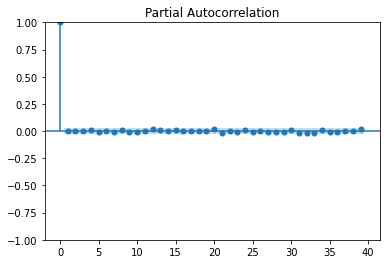

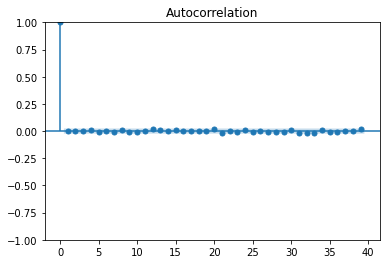

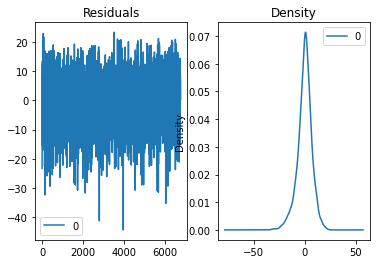

In [11]:
plot_pacf(best_model.resid)
plot_acf(best_model.resid)

residuals = pd.DataFrame(best_model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -156.679
2010-01
2010-02
2010-03
2011-01
2011-02
2011-03
2012-01
2012-02
2012-03
2013-01
2013-02
2013-03
2014-01
2014-02
2014-03
2015-01
2015-02
2015-03
2016-01
2016-02
2016-03
2017-01
2017-02
2017-03
2018-01
2018-02
2018-03
2019-01
2019-02
2019-03
2020-01
2020-02
2020-03
2021-01
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10629.4    0.00327104       298.612           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10635.2    0.00546017       399.486           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10638   0.000203618       93.8937           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       10638.1   5.10599e-05       74.8728   6.752

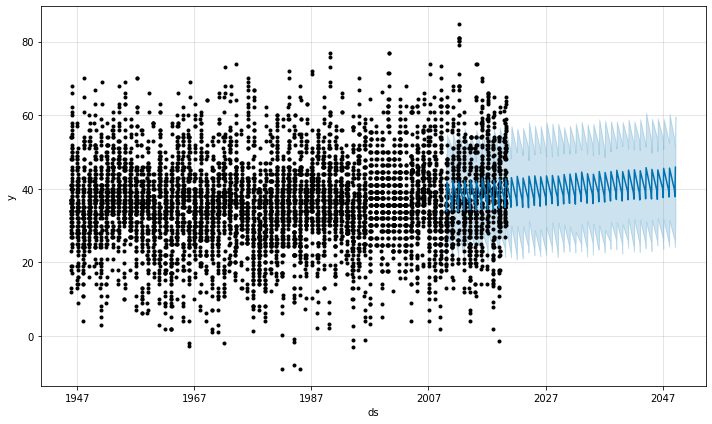

In [32]:
# model = ARIMA(winter_avg_df['avg'], order=(2,0,2))
# results_ARIMA = model.fit()

# plt.show()
# plt.figure(figsize=(20, 10))
# plt.plot(winter_avg_df['avg'])
# plt.plot(results_ARIMA.fittedvalues, color='red')

from fbprophet import Prophet
import pystan
# define the model
model = Prophet()
# fit the model
# winter_avg_df['ds'] = winter_avg_df.index
# winter_avg_df.columns = ['y', 'ds']
test_df = winter_df[['date', 'max']]
test_df.set_index('date', inplace = True)
test_df['ds'] = test_df.index
test_df.columns = ['y', 'ds']
# model.fit(winter_avg_df)
model.fit(test_df)
# # define the period for which we want a prediction
future = list()
for j in range(2010, 2050):
    for i in range(1, 4):
        date = str(j)
        date += '-%02d' % i
        future.append([date])
        print(date)
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# # use the model to make a forecast
forecast = model.predict(future)
# # summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# # plot forecast
model.plot(forecast)
plt.show()
